# Paralelizacion

### Tipos de Paralelilzacion
Hay diversos tipos de paralelizacion, revisaremos un par y mostraremos su eficiencia.

- *Multiprocesamiento*: es la ejecución simultánea de múltiples procesos utilizando más de un procesador. En este contexto, un proceso es una cadena de instrucciones (es decir, un programa). El multiprocesamiento se puede llevar a cabo en una máquina con múltiples CPU. Con el multiprocesamiento, cada proceso tiene su propio espacio de memoria, aunque el chip de memoria física puede compartirse.

- *Subprocesos multiples*: son similares al multiprocesamiento, excepto que, durante la ejecución, todos los subprocesos comparten el mismo espacio de memoria. Python tiene dificultades para implementar subprocesos múltiples debido a algunas características de diseño heredadas. Pero esto no es una restricción para bibliotecas científicas como NumPy y Numba. Las funciones importadas de estas bibliotecas y el código compilado JIT se ejecutan en entornos de ejecución de bajo nivel donde no se aplican las restricciones heredadas de Python.


### Ventajas y desventajas

Los subprocesos múltiples son más livianos porque la mayoría de los recursos del sistema y de la memoria son compartidos por los subprocesos. Además, el hecho de que varios subprocesos accedan a un grupo de memoria compartido es extremadamente conveniente para la programación numérica.Por otro lado, el multiprocesamiento es más flexible y se puede distribuir entre clústeres.

In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt

%matplotlib inline

## Subprocesos multiples implicitos en Numpy

La libreria NumPy utiliza subprocesos multiples en su codificacion.

In [2]:
# creacmos aleatoriamente matrices y buscamos sus valores propios
n = 20
m = 1000
for i in range(n):
    X = np.random.randn(m, m)
    λ = np.linalg.eigvals(X)

En los ultimos anos NumPy a logrado llevar este multiprocesamiento a mas de sus funciones, por ejemplo:

In [3]:
def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

In [4]:
grid = np.linspace(-3, 3, 5000)
x, y = np.meshgrid(grid, grid)

In [5]:
%timeit np.max(f(x, y))

538 ms ± 42.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Comparemos con Numba

In [6]:
from numba import vectorize

In [7]:
# Vectoricemos la funcion
@vectorize
def f_vec(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

In [8]:
np.max(f_vec(x, y))  # corremos para compilar

0.9999992797121728

In [9]:
%timeit np.max(f_vec(x, y))

286 ms ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Subproceos multiples una Ufunc Numba

Podemos tener la eficiencia de la función compilada JIT altamente especializada de Numba y las ganancias de velocidad de la paralelización obtenidas por el subprocesamiento múltiple implícito de NumPy?

Resulta que podemos, agregando algún tipo de información más ``target = parallel``.

In [10]:
@vectorize('float64(float64, float64)', target='parallel')
def f_vec(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

np.max(f_vec(x, y))  # Correr una vez para compilar

0.9999992797121728

In [11]:
%timeit np.max(f_vec(x, y))

111 ms ± 4.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Lazos de subprocesos multiples en Numba

Acabamos de ver un enfoque de paralelización en Numba, usando el indicador paralelo en `@vectorize`. Esto es bueno, pero resulta que no se adapta bien a muchos de los problemas. Afortunadamente, Numba proporciona otro enfoque para subprocesos múltiples que funcionará para nosotros en casi todos los lugares donde la paralelización es posible. Veamos primero un código simple, de un solo subproceso.

El codigo calculara $w_t$ por medio de
$$w_{t+1}=R_{t+1}sw_t+y_{t+1}.$$


In [12]:
from numpy.random import randn
from numba import njit

In [13]:
@njit
def h(w, r=0.1, s=0.3, v1=0.1, v2=1.0):
    
    R = np.exp(v1 * randn()) * (1 + r)
    y = np.exp(v2 * randn())

    w = R * s * w + y
    return w

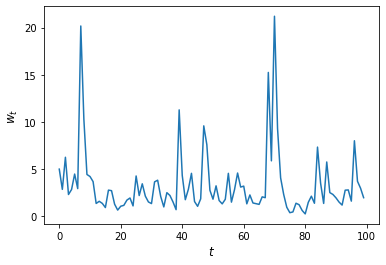

In [14]:
fig, ax = plt.subplots()

T = 100
w = np.empty(T)
w[0] = 5
for t in range(T-1):
    w[t+1] = h(w[t])

ax.plot(w)
ax.set_xlabel('$t$', fontsize=12)
ax.set_ylabel('$w_{t}$', fontsize=12)
plt.show()